In [271]:
# Necessary imports
import pandas as pd
from sklearn.model_selection import train_test_split as tts
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn import tree
import matplotlib.pyplot as plt

In [272]:
def load_data():
    # Define the column names
    column_names = ['parents', 'has_nurs', 'form', 'children', 'housing', 'finance', 'social', 'health', 'class']

    # Load the data and add column names
    data = pd.read_csv('data/nursery.data', delimiter=',', names=column_names)

    return data

In [273]:
data = load_data()

# Print the shape of the data
print("Data Shape: ", data.shape)

# Print the first 10 rows
print(data.head(10).to_string(), "\n")

Data Shape:  (12960, 9)
  parents has_nurs      form children     housing     finance         social       health       class
0   usual   proper  complete        1  convenient  convenient        nonprob  recommended   recommend
1   usual   proper  complete        1  convenient  convenient        nonprob     priority    priority
2   usual   proper  complete        1  convenient  convenient        nonprob    not_recom   not_recom
3   usual   proper  complete        1  convenient  convenient  slightly_prob  recommended   recommend
4   usual   proper  complete        1  convenient  convenient  slightly_prob     priority    priority
5   usual   proper  complete        1  convenient  convenient  slightly_prob    not_recom   not_recom
6   usual   proper  complete        1  convenient  convenient    problematic  recommended    priority
7   usual   proper  complete        1  convenient  convenient    problematic     priority    priority
8   usual   proper  complete        1  convenient  conveni

In [274]:
# Get information about the data
print(data.describe().to_string(), "\n")

# Check if there are missing values
print(data.isnull().sum())

# Check the unique values in the class column
print(data['class'].value_counts())

       parents has_nurs      form children     housing     finance   social       health      class
count    12960    12960     12960    12960       12960       12960    12960        12960      12960
unique       3        5         4        4           3           2        3            3          5
top      usual   proper  complete        1  convenient  convenient  nonprob  recommended  not_recom
freq      4320     2592      3240     3240        4320        6480     4320         4320       4320 

parents     0
has_nurs    0
form        0
children    0
housing     0
finance     0
social      0
health      0
class       0
dtype: int64
class
not_recom     4320
priority      4266
spec_prior    4044
very_recom     328
recommend        2
Name: count, dtype: int64


In [275]:
def split_data(data):
    # Separate the features and target variable before encoding
    X = data.drop('class', axis=1)
    y = data['class']

    X_encoded = pd.get_dummies(X)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = tts(X_encoded, y, test_size=0.5, random_state=13)

    return X_train, X_test, y_train, y_test, X_encoded, y

In [381]:
def training(criteria, X_train, y_train):
    # Train the model with criteria
    model = DecisionTreeClassifier(criterion=criteria, random_state=13, max_depth=3, min_samples_leaf=1, class_weight={'not_recom': 1, 'priority': 1, 'recommend': 1, 'spec_prior': 1, 'very_recom': 1})

    # Fit the model
    model.fit(X_train, y_train)

    return model

In [382]:
def predict(model, X_test):
    # Predict the target variable
    y_pred = model.predict(X_test)

    return y_pred

In [383]:
def evaluate(y_test, y_pred):
    # Evaluate the model
    confusion = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, zero_division=1)

    return confusion, classification_rep

In [384]:
# Split the data
X_train, X_test, y_train, y_test, X_encoded, y = split_data(data)

# Train the model with gini
gini_model = training("gini", X_train, y_train)

# Train the model with entropy
entropy_model = training("entropy", X_train, y_train)

# Prediction and evaluation
y_pred_gini = predict(gini_model, X_test)
confusion_gini, classification_gini = evaluate(y_test, y_pred_gini)

# Prediction and evaluation
y_pred_entropy = predict(entropy_model, X_test)
confusion_entropy, classification_entropy = evaluate(y_test, y_pred_entropy)

# Grid search
param_grid = {
    'min_samples_leaf': [1, 2, 3]
}

grid_search_gini = GridSearchCV(gini_model, param_grid, cv=2)
grid_search_gini.fit(X_encoded, y)

grid_search_entropy = GridSearchCV(entropy_model, param_grid, cv=2)
grid_search_entropy.fit(X_encoded, y)



GridSearchCV(cv=2,
             estimator=DecisionTreeClassifier(class_weight={'not_recom': 1,
                                                            'priority': 1,
                                                            'recommend': 1,
                                                            'spec_prior': 1,
                                                            'very_recom': 1},
                                              criterion='entropy', max_depth=3,
                                              random_state=13),
             param_grid={'min_samples_leaf': [1, 2, 3]})

In [385]:
# Prints
print("Gini Index")
print("Confusion Matrix: \n", confusion_gini)
print("Classification Report: \n", classification_gini)

print("Best parameters: ", grid_search_gini.best_params_)
print("Best score: ", grid_search_gini.best_score_)

# Perform cross-validation with best model
best_model = grid_search_gini.best_estimator_
scores = cross_val_score(best_model, X_encoded, y, cv=2)

print("Cross-validation scores: ", scores)
print("Average cross-validation score: ", scores.mean())

Gini Index
Confusion Matrix: 
 [[2102    0    0    0    0]
 [   0 1681    0  505    0]
 [   0    1    0    0    0]
 [   0  513    0 1506    0]
 [   0  172    0    0    0]]
Classification Report: 
               precision    recall  f1-score   support

   not_recom       1.00      1.00      1.00      2102
    priority       0.71      0.77      0.74      2186
   recommend       1.00      0.00      0.00         1
  spec_prior       0.75      0.75      0.75      2019
  very_recom       1.00      0.00      0.00       172

    accuracy                           0.82      6480
   macro avg       0.89      0.50      0.50      6480
weighted avg       0.82      0.82      0.81      6480

Best parameters:  {'min_samples_leaf': 1}
Best score:  0.5927469135802469
Cross-validation scores:  [0.48256173 0.7029321 ]
Average cross-validation score:  0.5927469135802469


In [386]:
# Prints
print("Entropy")
print("Confusion Matrix: \n", confusion_entropy)
print("Classification Report: \n", classification_entropy)

print("Best parameters: ", grid_search_entropy.best_params_)
print("Best score: ", grid_search_entropy.best_score_)

# Perform cross-validation with best model
best_model2 = grid_search_entropy.best_estimator_
scores2 = cross_val_score(best_model2, X_encoded, y, cv=2)

print("Cross-validation scores: ", scores2)
print("Average cross-validation score: ", scores2.mean())

Entropy
Confusion Matrix: 
 [[2102    0    0    0    0]
 [   0 1681    0  505    0]
 [   0    1    0    0    0]
 [   0  513    0 1506    0]
 [   0  172    0    0    0]]
Classification Report: 
               precision    recall  f1-score   support

   not_recom       1.00      1.00      1.00      2102
    priority       0.71      0.77      0.74      2186
   recommend       1.00      0.00      0.00         1
  spec_prior       0.75      0.75      0.75      2019
  very_recom       1.00      0.00      0.00       172

    accuracy                           0.82      6480
   macro avg       0.89      0.50      0.50      6480
weighted avg       0.82      0.82      0.81      6480

Best parameters:  {'min_samples_leaf': 1}
Best score:  0.682716049382716
Cross-validation scores:  [0.6625    0.7029321]
Average cross-validation score:  0.682716049382716


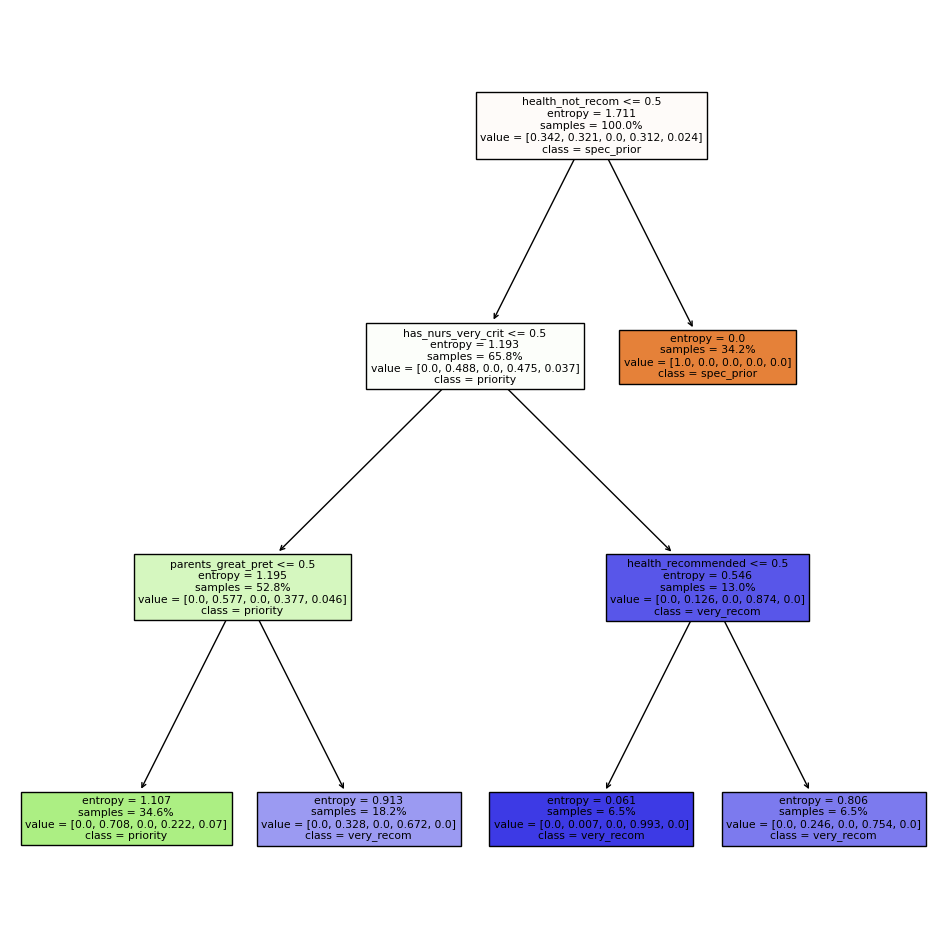

In [387]:
# Get the feature names
feature_names = X_train.columns.tolist()
class_names = y_train.unique().tolist()

# Assuming clf is your trained decision tree classifier
fig, ax = plt.subplots(figsize=(12, 12))  # Adjust size as needed
tree.plot_tree(entropy_model, filled=True, feature_names=feature_names, class_names=class_names, ax=ax, proportion=True)
plt.show()

# from sklearn.tree import export_graphviz

# export_graphviz(clf, out_file='tree.dot', 
#                 feature_names=feature_names,  # replace with your real feature names
#                 class_names=class_names,  # replace with your real class names
#                 filled=True)

# # Convert to PNG using system command (requires Graphviz)
# !dot -Tpng tree.dot -o tree.png